In [1]:
%matplotlib notebook
import pymunk
import pymunk.matplotlib_util
from pymunk.vec2d import Vec2d
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation

import math, functools, random, traceback

import numpy as np

def print_errors_to_stdout(fun):
    @functools.wraps(fun)
    def wrapper(*args,**kw):
        try:
            return fun(*args,**kw)
        except Exception:
            traceback.print_exc()
            raise
    return wrapper

In [11]:
class Gripper:
    
    filter = pymunk.ShapeFilter(categories=0b01, mask=0b10)
    
    def __init__(self, x, y, angle, distance=200, length=200, velocity=50):
        # computing slope, slope of perpendicular
        self.slope = math.tan(angle)
        self.orth_slope = -1/self.slope if not np.isclose(0, self.slope) else -math.inf
        length, distance = length / 2, distance / 2
        
        if math.isfinite(self.orth_slope):
            # starting position offsets
            self.x_offset = distance/math.sqrt(self.orth_slope**2+1)
            self.y_offset = (self.orth_slope*distance)/math.sqrt(self.orth_slope**2+1)

            # squeeze velocity components, magnitude of velocity vector = velocity
            self.vel_x = velocity/math.sqrt(self.orth_slope**2+1)
            self.vel_y = velocity*self.orth_slope/math.sqrt(self.orth_slope**2+1)
        else:
            self.x_offset = 0
            self.y_offset = distance
            
            self.vel_x = 0
            self.vel_y = velocity
        
        # bottom gripper
        self.bot_vel = Vec2d(self.vel_x, self.vel_y) # squeeze velocity vector
        self.bot_pos = Vec2d(x-self.x_offset, y-self.y_offset) # starting position vector
        self.bot_limiter = Gripper.make_unsqueeze_limiter(self.bot_pos)
        
        self.bot = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        self.bot.position = self.bot_pos
        self.bot_seg = pymunk.Segment(self.bot, a=(-length, 0), b=(length, 0), radius=2)
        self.bot_seg.friction = 0
        self.bot_seg.filter = Gripper.filter
        self.bot.angle = angle
        
        # top gripper
        self.top_vel = -Vec2d(self.vel_x, self.vel_y) # squeeze velocity vector
        self.top_pos = Vec2d(x+self.x_offset, y+self.y_offset) # starting position vector
        self.top_limiter = Gripper.make_unsqueeze_limiter(self.top_pos)
        
        self.top = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        self.top.position = self.top_pos
        self.top_seg = pymunk.Segment(self.top, a=(-length, 0), b=(length, 0), radius=2)
        self.top_seg.friction = 0
        self.top_seg.filter = Gripper.filter
        self.top.angle = angle
    
    @staticmethod
    def make_unsqueeze_limiter(pos, eps=1):
        def position_func(body, dt):
            if (body.position - pos).length < eps:
                body.velocity = 0, 0
            pymunk.Body.update_position(body, dt)
                
        return position_func
    
    def make_squeeze_limiter(polygon):
        def position_func(body, dt):
            pass
        
        return position_func
                
    def squeeze(self):
        self.bot.velocity = self.bot_vel
        self.top.velocity = self.top_vel
        
    def unsqueeze(self):
        self.bot.velocity = -self.bot_vel
        self.top.velocity = -self.top_vel
    
    def stop(self):
        self.bot.velocity = 0, 0
        self.top.velocity = 0, 0
        
    def limit_position(self):
        self.bot.position_func = self.bot_limiter
        self.top.position_func = self.top_limiter
        
    def reset_pos_func(self):
        self.bot.position_func = pymunk.Body.update_position
        self.top.position_func = pymunk.Body.update_position
        
    def reset_vel_func(self):
        self.bot.velocity_func = pymunk.Body.update_velocity
        self.top.velocity_func = pymunk.Body.update_velocity
        
    def distance(self):
        return self.bot.position.get_distance(self.top.position)

In [12]:
class Polygon:
    
    squeeze_filter = pymunk.ShapeFilter(categories=0b10, mask=pymunk.ShapeFilter.ALL_MASKS())
    move_filter = pymunk.ShapeFilter(categories=0b10, mask=pymunk.ShapeFilter.ALL_MASKS() ^ 0b01)
    
    gripper_pos = []
    del_pos = math.inf
    state = 0
    
    def __init__(self, x, y, points, angle=None):
        self.points = list(map(tuple, points))
        self.body = pymunk.Body(1, 10000, body_type=pymunk.Body.DYNAMIC)
        self.body.position = x, y
        
        self.poly = pymunk.Poly(self.body, self.points)
        self.poly.friction = 0
        
        if angle is None:
            self.body.angle = random.uniform(0, 2*math.pi)
        
    def reset_pos_func(self):
        self.body.position_func = pymunk.Body.update_position
        
    def reset_vel_func(self):
        self.body.velocity_func = pymunk.Body.update_velocity
        
    def move(self):
        self.body.velocity = 100, 0
        self.poly.filter = Polygon.move_filter
        self.body.velocity_func = Polygon.constant_angular_velocity
        self.body.position_func = Polygon.limit_pos
        
    def squeeze(self):
        self.poly.filter = Polygon.squeeze_filter
        self.reset_vel_func()
        
    @staticmethod
    def limit_pos(body, dt):
        if int(body.position.x) in Polygon.gripper_pos and Polygon.state >= 5:
            body.velocity = body.velocity * 0
        if body.position.x >= Polygon.del_pos:
            space.remove(body, *body.shapes)
        
        pymunk.Body.update_position(body, dt)
        
    @staticmethod
    def constant_angular_velocity(body, gravity, damping, dt):
        pymunk.Body.update_velocity(body, gravity, damping, dt)
        body.angular_velocity = 0

In [13]:
class Display:
    
    MOVE_PART_TIME = 200
    SQUEEZE_PART_TIME = 150
    UNSQUEEZE_PART_TIME = 150
    TOTAL_TIME = MOVE_PART_TIME + SQUEEZE_PART_TIME + UNSQUEEZE_PART_TIME
    
    def __init__(self, points, angles):
        self.angles = angles
        self.points = points
        
        self.fig = plt.figure(figsize=(8, 5), tight_layout=True)
        
        self.gripper_pos = [i * 250 for i in range(1, len(angles)+1)]
        self.start_pos = 0
        self.del_pos = (len(angles) + 1) * 250
        
        self.xlim = (self.start_pos, self.del_pos)
        self.ylim = (-200, 200)
        
        self.ax = plt.axes(xlim=self.xlim, ylim=self.ylim)
        self.ax.set_aspect('equal')
        
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 1
        
        self.init_grippers()    
        self.polygons = []
    
        self.do = pymunk.matplotlib_util.DrawOptions(self.ax)
        
        Polygon.gripper_pos = self.gripper_pos
        Polygon.del_pos = self.del_pos
        
    def init_grippers(self):
        self.grippers = []
        
        for angle, xpos in zip(self.angles, self.gripper_pos):
            g = Gripper(xpos, 0, angle)
            
            self.grippers.append(g)
            self.space.add(g.top, g.top_seg)
            self.space.add(g.bot, g.bot_seg)
    
    def add_polygon(self):
        p = Polygon(self.start_pos, 0, self.points)
        self.polygons.insert(0, p)
        self.space.add(p.body, p.poly)
        
    def make_animation(self):
        animate = self.make_animate_func()
        init = lambda: self.space.debug_draw(self.do)
        self.anim = animation.FuncAnimation(self.fig, animate, init_func=init, 
                                            frames=Display.TOTAL_TIME, interval=2, blit=False)        
    
    def make_animate_func(self):     
        def animate(dt):
            dt = dt % 500
            Polygon.state = dt
            if dt == 0:
                # create a new box; start moving all boxes to next one
                self.add_polygon()

                for p in self.polygons:
                    p.move()
            elif 0 < dt < 200:
                pass
            elif dt == 200:
                for p in self.polygons:
                    p.squeeze()

                for g in self.grippers:  
                    g.reset_pos_func()
                    g.squeeze()          
            elif 200 < dt < 350:
                for g in self.grippers: 
                    distance = g.distance()
                    if distance < 50:
                        g.stop()
            elif dt == 350:
                for p in self.polygons:
                    p.body.velocity_func = Polygon.constant_angular_velocity

                for g in self.grippers:
                    g.unsqueeze()
                    g.limit_position()
            elif dt > 350:
                pass

            for x in range(10):
                self.space.step(1/50/10)
            self.ax.clear()
            self.ax.set_xlim(*self.xlim)
            self.ax.set_ylim(*self.ylim)
            self.space.debug_draw(self.do)

            self.ax.set_title(f'{dt}')
            
        return animate

<IPython.core.display.Javascript object>


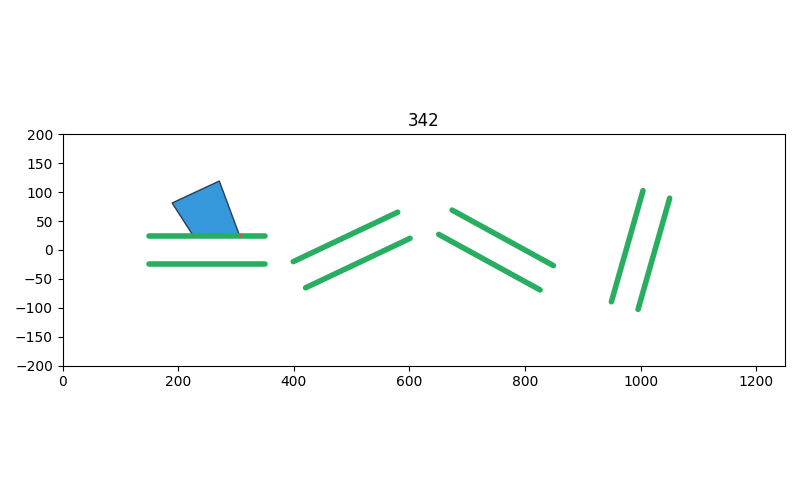

In [14]:
# points = list(map(tuple, np.array([(-25, -33), (25, -33), (25, 20), (0, 45), (-25, 20)])))
angles = [0, 0.4419893385181256, -0.5011276212381935, 1.2937195578711362]
points = np.array([(-42, -41), (48, -41), (39, 25), (-34, 59)])

d = Display(points, angles)
d.make_animation()